# This notebook creates the data for Figure 4 (b)

In [4]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../../")

import pickle
import cycler
import numpy as np
import tensorflow as tf
import tensorflow_gnn as tfgnn
import keras
import tensorflow_gnn.proto.graph_schema_pb2 as schema_pb2
from google.protobuf import text_format

from pathlib import Path
import matplotlib.pyplot as plt

import zxreinforce.own_constants as oc
from zxreinforce.batch_utils import batch_obs_combined_traj, batch_mask_combined
from zxreinforce.rl_schemas import OBSERVATION_SCHEMA_ZX_MAX
from zxreinforce.VecAsyncEnvironment import VecZXCalculus
from zxreinforce.Resetters import Resetter_Test_COPY
from zxreinforce.PPO_Agent_mult_GPU import PPOAgentPara
from zxreinforce.RL_Models_Max import build_gnn_actor_model, build_gnn_critic_model
from zxreinforce.batch_utils import batch_mask_combined, batch_obs_combined_traj
from zxreinforce.action_conversion_utils import get_action_index

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
color_palette_ibm = ['#648fff', '#ffb000', '#dc267f', '#785ef0', '#fe6100']
cycler_color_palette_ibm = cycler.cycler(color=color_palette_ibm)

def nice_plot_x_y(x_list, y_list, label_list=None, ylims=(None, None), ylabel="", xlabel="",
              savename=None, color_cycler=cycler_color_palette_ibm,
              figsize=(10,2), yscale=None):
    '''to_plot: list of keys
    step_dict: dict of xvalues for each key
    value_dict: dict of yvalues for each key'''
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_prop_cycle(color_cycler)
    if label_list:
        for x, y, label in zip(x_list, y_list, label_list):
            ax.plot(x, y, label=label, marker="x")
    else:
        for x, y in zip(x_list, y_list):
            ax.plot(x, y, marker="x")
    ax.tick_params(direction="in", right=True, top=True)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    ax.legend()
    ax.grid()
    if yscale:
        ax.set_yscale(yscale)
    if savename:
        plt.savefig(savename)

    ax.set_ylim(ylims)
    plt.show()

In [6]:
# Load agent
graph_schema = text_format.Merge(OBSERVATION_SCHEMA_ZX_MAX, schema_pb2.GraphSchema())
graph_tensor_spec = tfgnn.create_graph_spec_from_schema_pb(graph_schema)

strategy = tf.distribute.MirroredStrategy(["GPU:0", "GPU:1"])

with strategy.scope():
    actor_model = build_gnn_actor_model(graph_tensor_spec=graph_tensor_spec)
    critic_model = build_gnn_critic_model(graph_tensor_spec=graph_tensor_spec)
    optimizer = keras.optimizers.Adam()


load_idx = 400
load_path = Path("../../saved_agents/normal_seed=1_20240412-204341/saved_agent")
ppo_agent = PPOAgentPara.load_from_folder(load_path, actor_model, critic_model, optimizer, strategy, load_idx)


2024-04-25 13:31:06.074183: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22996 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:3b:00.0, compute capability: 7.5
2024-04-25 13:31:06.075008: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22996 MB memory:  -> device: 1, name: Quadro RTX 6000, pci bus id: 0000:86:00.0, compute capability: 7.5


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: annotated name 'piece_name' can't be nonlocal (__autograph_generated_fileq6nbxbqb.py, line 18)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: annotated name 'piece_name' can't be nonlocal (__autograph_generated_fileq6nbxbqb.py, line 18)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2024-04-25 13:31:08.723033: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder_1' with dtype int32 and shape [1]
	 [[{{node Placeholder_1}}]]
2024-04-25 13:31:08.723136: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder_1' with dtype int32 and shape [1]
	 [[{{node Placeholder_1}}]]
2024-04-25 13:31:08.826894: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder_3' with dtype int32 and shape [1]
	 [[{{node Plac

# Eval COPY

In [7]:

n_out_list = np.arange(1, 10)

prob_copy_list = np.zeros((len(n_out_list), len(n_out_list)+1))
for i, n_out in enumerate(n_out_list):
    for n_extra_node in range(0, n_out+1):
        resetter = Resetter_Test_COPY(n_out=n_out,
                                    n_extra_node=n_extra_node, 
                                    angle_copy=oc.ZERO,
                                    color_zero=oc.GREEN, 
                                    angles_out=oc.ARBITRARY, 
                                    angle_other=oc.ARBITRARY)

        env = VecZXCalculus(max_steps=200, 
                            n_envs=1,
                            add_reward_per_step=0,
                            resetter_list=[resetter,]* 1,
                            check_consistencty=True)

        observation, mask = env.reset()
        pi_rule_idx = get_action_index(observation[0][-3], observation[0][-2], "copy_rule_right", 0)
        distr = ppo_agent._get_distribution(batch_obs_combined_traj(observation), batch_mask_combined(mask))
        probs = tf.exp(tf.math.log_softmax(distr.logits[0]))
        prob_copy_list[i, n_extra_node] = probs[pi_rule_idx]

/u/mnaegel/conda-envs/tf_gnn_4/lib/python3.9/site-packages/numba/core/ir_utils.py:2149: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'mask_list' of function 'batch_mask_np_jit'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../zxreinforce/batch_utils.py", line 193:
@numba.njit
def batch_mask_np_jit(mask_list:list)-> np.ndarray:
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


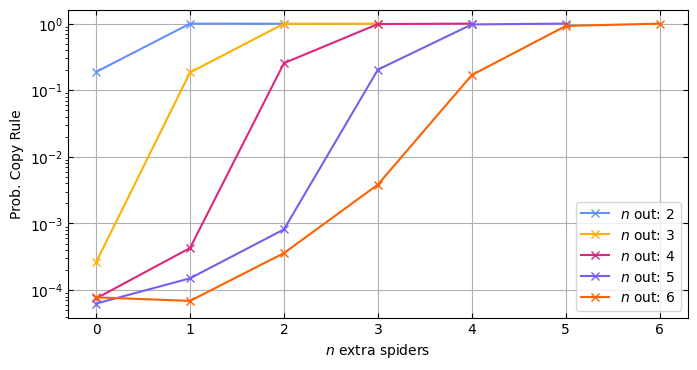

In [8]:
idx_list = [1, 2, 3, 4, 5]
x_list = [range(n_out_list[i]+1) for i in idx_list]
y_list = [prob_copy_list[i][:n_out_list[i]+1] for i in idx_list]
label_list = [f"$n$ out: {n_out_list[i]}" for i in idx_list]

nice_plot_x_y(x_list, y_list, label_list=label_list, ylabel="Prob. Copy Rule", xlabel="$n$ extra spiders",
              savename=None, yscale="log", figsize=(8,4))

In [9]:
with open("prob_copy_list.pkl", "wb") as f:
    pickle.dump(prob_copy_list, f)